# Robotic Systems II (ECE-DK904)

## Electrical and Computer Engineering Department, University of Patras, Greece

**Instructor:** Konstantinos Chatzilygeroudis (costashatz@upatras.gr)

## Lab 5

### Real-time controller for the Planar Quadrotor

<div>
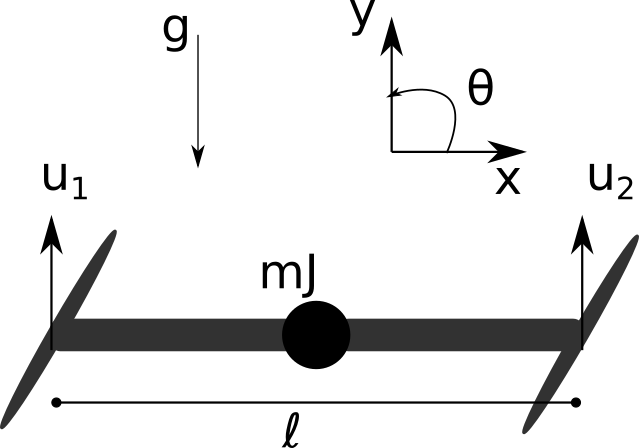
</div>

$\boldsymbol{x} = \begin{bmatrix}\boldsymbol{q}\\\dot{\boldsymbol{q}}\end{bmatrix}$

$\boldsymbol{u} = \begin{bmatrix}u_1\\u_2\end{bmatrix}$

where

$\boldsymbol{q} = \begin{bmatrix}x\\y\\\theta\end{bmatrix}\in\mathbb{R}^3$

$\dot{\boldsymbol{q}} = \begin{bmatrix}\dot{x}\\\dot{y}\\\dot{\theta}\end{bmatrix}\in\mathbb{R}^3$

**Planar Quadrotor Dynamics**

$\ddot{\boldsymbol{q}} = \begin{bmatrix}\ddot{x}\\\ddot{y}\\\ddot{\theta}\end{bmatrix}=\begin{bmatrix}\frac{-(u_1+u_2)\text{sin}\theta}{m}\\\frac{(u_1+u_2)\text{cos}\theta}{m}-g\\\frac{l(u_2-u_1)}{2J}\end{bmatrix}$

Let's write down the dynamics:

In [1]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
# JAX - Linear Algebra with automatic differentiation
import jax.numpy as jnp
from jax import jacfwd, jit

# Make JAX use float64 by default!
from jax.config import config; config.update("jax_enable_x64", True)

/tmp/ipykernel_1706/929737274.py:8: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config; config.update("jax_enable_x64", True)


In [2]:
# Global vars for ease of use
dt = 0.05
m = 1.
g = 9.81
l = 0.3
J = 0.2 * m * l * l

def planar_quad(x, u):
    ### TO-DO: Write down the dynamics (fill x_dot)
    q = x[:3,:]
    q_dot = x[3:,:]

    theta = q[2,0]
    u1 = u[0,0]
    u2 = u[1,0]
    
    q_ddot = jnp.array([[-((u1 + u2) * jnp.sin(theta))/m, ((u1 + u2) * jnp.cos(theta))/m - g, l * ((u2 - u1)/(2*J))]]).reshape(3,1)
    
    x_dot = jnp.block([[q_dot], [q_ddot]])
    ### END of TO-DO
    return x_dot

def planar_quad_rk4(x, u, dt = 0.05):
    f1 = planar_quad(x, u)
    f2 = planar_quad(x + 0.5 * dt * f1, u)
    f3 = planar_quad(x + 0.5 * dt * f2, u)
    f4 = planar_quad(x + dt * f3, u)
    x_n = x + (dt/6.)*(f1 + 2. * f2 + 2. * f3 + f4)
    return x_n

### Linearization around a fixed point!

Let's assume that we have a system with the following discrete dynamics:
$\boldsymbol{x}_{k+1} = f_{\text{discrete}}(\boldsymbol{x}_k, \boldsymbol{u}_k)$


A fixed point $(\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}})$ is defined as follows:
$\bar{\boldsymbol{x}} = f_{\text{discrete}}(\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}})$

To **linearize around that fixed point**, we take the Taylor Series around $\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}}$:

$\boldsymbol{x}_{k+1} = f_{\text{discrete}}(\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}}) + \underbrace{\frac{\partial f_{\text{discrete}}}{\partial\boldsymbol{x}}\Big|_{\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}}}}_{\boldsymbol{A}}(\boldsymbol{x}_k-\bar{\boldsymbol{x}}) + \underbrace{\frac{\partial f_{\text{discrete}}}{\partial\boldsymbol{u}}\Big|_{\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}}}}_{\boldsymbol{B}}(\boldsymbol{u}_k-\bar{\boldsymbol{u}})$

We can simplify and write:

$\bar{\boldsymbol{x}} + \Delta\boldsymbol{x}_{k+1} = f_{\text{discrete}}(\bar{\boldsymbol{x}}, \bar{\boldsymbol{u}}) + \boldsymbol{A}\Delta\boldsymbol{x}_k + \boldsymbol{B}\Delta\boldsymbol{u}_k$

$\Delta\boldsymbol{x}_{k+1} = \boldsymbol{A}\Delta\boldsymbol{x}_k + \boldsymbol{B}\Delta\boldsymbol{u}_k$

**Now we can do LQR on** $\Delta\boldsymbol{x},\Delta\boldsymbol{u}$!

**Let's linearize the Planar Quadrotor** around $\boldsymbol{x} = \begin{bmatrix}x & y & 0 & 0 & 0 & 0\end{bmatrix}^T$ and $\boldsymbol{u} = \begin{bmatrix}\frac{mg}{2} & \frac{mg}{2}\end{bmatrix}^T$. In other words, we do not care about $x,y$ and we want to linearize around zero angle ($\theta$), zero velocities ($\dot{\boldsymbol{q}}$) and the *"hover"* controls.

Let's write down the $\boldsymbol{A}$ and $\boldsymbol{B}$ matrices:

In [3]:
x_bar = np.zeros((6, 1))
u_bar = np.array([[m*g/2., m*g/2.]]).T

### TO-DO: Write the A and B matrices (use jax automatic differentiation!)
A = (jacfwd(planar_quad_rk4, argnums=0)(x_bar, u_bar)).reshape(6,6)
B = (jacfwd(planar_quad_rk4, argnums=1)(x_bar, u_bar)).reshape(6,2)
### END of TO-DO

jnp.set_printoptions(precision=2, suppress=True)
print(A)
print(B)

[[ 1.    0.   -0.01  0.05  0.   -0.  ]
 [ 0.    1.    0.    0.    0.05  0.  ]
 [ 0.    0.    1.    0.    0.    0.05]
 [ 0.    0.   -0.49  1.    0.   -0.01]
 [ 0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]
[[ 0.   -0.  ]
 [ 0.    0.  ]
 [-0.01  0.01]
 [ 0.   -0.  ]
 [ 0.05  0.05]
 [-0.42  0.42]]


### Convex Model Predictive Control (MPC) for the Planar Quadrotor!

Let's do MPC for this quadrotor! Let's first define some helper variables:

In [4]:
N = 6 ### TO-DO: dimension of state
M = 2 ### TO-DO: dimension of action

# Cost
Q = np.eye(N)
R = 0.01 * np.eye(M)
QN = np.eye(N)

# Cost with reference/target
def cost(xs, us, xref = np.zeros((N,1))):
    c = 0.5 * (xs[-1] - xref).T @ QN @ (xs[-1] - xref)
    for k in range(K-1):
        c += 0.5 * (xs[k] - xref).T @ Q @ (xs[k] - xref)
        c += 0.5 * us[k].T @ R @ us[k]
    return c[0][0]

Now we need to solve the infinite horizon LQR problem! There are many efficient ways of doing this, but we will do this "naively": run LQR for long enough and get the first $\boldsymbol{K}$ and $\boldsymbol{P}$ matrices! Alright, let's do this:

In [5]:
# Let's first compute the optimal K, P gains
#   Solve Riccati with K big!
K = 2000
# Book-keeping
us = [np.zeros((M, 1)) for _ in range(K-1)]

# Init
Ps = [np.zeros((N, N))]*K
Ks = [np.zeros((M, N))]*(K-1)

# Riccati backward
Ps[K-1] = QN
for k in range(K-2, -1, -1):
    tmp1 = (R + B.T @ Ps[k+1] @ B)
    tmp2 = B.T @ Ps[k+1] @ A
    Ks[k] = np.linalg.solve(tmp1, tmp2)
    ## From DP
    tmp = A - B @ Ks[k]
    Ps[k] = Q + Ks[k].T @ R @ Ks[k] + tmp.T @ Ps[k+1] @ tmp
    ## End from DP

# Let's take out the results we need
Kinf = Ks[0]
Pinf = Ps[0]

print(Kinf)
print(Pinf)

[[ 1.02  4.88 -6.3   1.53  5.36 -1.33]
 [-1.02  4.88  6.3  -1.53  5.36  1.33]]
[[ 30.07   0.   -22.99  11.85   0.    -0.55]
 [  0.    21.95  -0.     0.     1.5   -0.  ]
 [-22.99  -0.   125.88 -33.37  -0.     3.14]
 [ 11.85   0.   -33.37  15.68   0.    -0.81]
 [  0.     1.5   -0.     0.     2.11  -0.  ]
 [ -0.55  -0.     3.14  -0.81  -0.     1.11]]


**Let's first try a few things with the LQR controller!**

K= 101
35.02818198743733


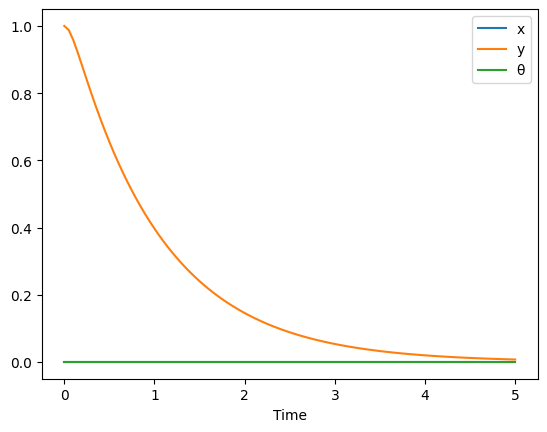

In [6]:
# Let's first do a simulation with the LQR controller!
tf = 5. # total time
K = round(tf/dt) + 1
print('K=', K)

# Initial state is 1m away in y-direction!
x0 = np.array([[0., 1., 0., 0., 0., 0.]]).T

us = []
states = [np.copy(x0)]
x = np.copy(x0)
for k in range(K-1):
    u_new = u_bar -Kinf @ x
    x = planar_quad_rk4(x, u_new, dt)
    states.append(np.copy(x))
    us.append(np.copy(u_new))
print(cost(states, us))

# Let's plot it
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [states[k][0, 0] for k in range(K)], label="x")
ax.plot([k * dt for k in range(K)], [states[k][1, 0] for k in range(K)], label="y")
ax.plot([k * dt for k in range(K)], [states[k][2, 0] for k in range(K)], label="θ")

plt.xlabel("Time")

plt.legend();

The LQR controller will always drive the system to **zero**. We can *command* the LQR controller to change the target as follows:

$\boldsymbol{u} = \bar{\boldsymbol{u}} - \boldsymbol{K}(\boldsymbol{x}-\boldsymbol{x}_{ref})$

Let's try it:

531.3322124295745


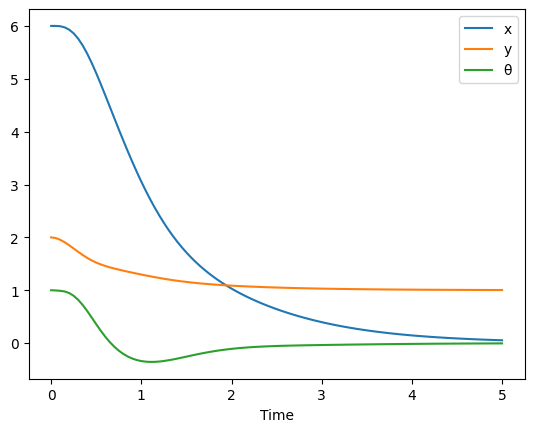

In [7]:
### TO-DO: Change x_ref
x_ref = np.array([[0., 1., 0., 0., 0., 0.]]).T
### END of TO-DO

# Initial State far away!
x0 = np.array([[6., 2., 1., 0., 0., 0.]]).T

us = []
states = [np.copy(x0)]
x = np.copy(x0)
for k in range(K-1):
    ### TO-DO: Implement reference controller
    u_new = u_bar - Kinf @ (x - x_ref)
    ### END of TO-DO
    x = planar_quad_rk4(x, u_new, dt)
    states.append(np.copy(x))
    us.append(np.copy(u_new))
print(cost(states, us, x_ref))

# Let's plot it
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [states[k][0, 0] for k in range(K)], label="x")
ax.plot([k * dt for k in range(K)], [states[k][1, 0] for k in range(K)], label="y")
ax.plot([k * dt for k in range(K)], [states[k][2, 0] for k in range(K)], label="θ")

plt.xlabel("Time")

plt.legend();

LQR does not account for actuation limits. Let's see what happens if our motors have limits.

56704.05358932096


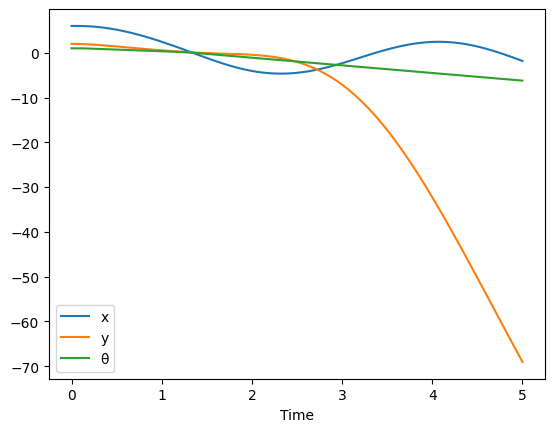

In [9]:
### TO-DO: Change x_ref
x_ref = np.array([[0., 1., 0., 0., 0., 0.]]).T
### END of TO-DO

# Initial State far away!
x0 = np.array([[6., 2., 1., 0., 0., 0.]]).T

# Actuation Limits
u_min = np.array([[0.2*m*g, 0.2*m*g]]).T
u_max = np.array([[0.6*m*g, 0.6*m*g]]).T

us = []
states = [np.copy(x0)]
x = np.copy(x0)
for k in range(K-1):
    ### TO-DO: Copy reference controller from above
    u_new = u_bar - Kinf @ (x - x_ref)
    ### END of TO-DO
    ### TO-DO: Clamp u_new inside u_min/u_max (use np.minimum/maximum functions)
    u_new = np.minimum(np.maximum(u_new, u_min), u_max)
    ### END of TO-DO
    x = planar_quad_rk4(x, u_new, dt)
    states.append(np.copy(x))
    us.append(np.copy(u_new))
print(cost(states, us, x_ref))

# Let's plot it
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [states[k][0, 0] for k in range(K)], label="x")
ax.plot([k * dt for k in range(K)], [states[k][1, 0] for k in range(K)], label="y")
ax.plot([k * dt for k in range(K)], [states[k][2, 0] for k in range(K)], label="θ")

plt.xlabel("Time")

plt.legend();

LQR blows up with actuation limits! Let's plot the commands to see what is happening!

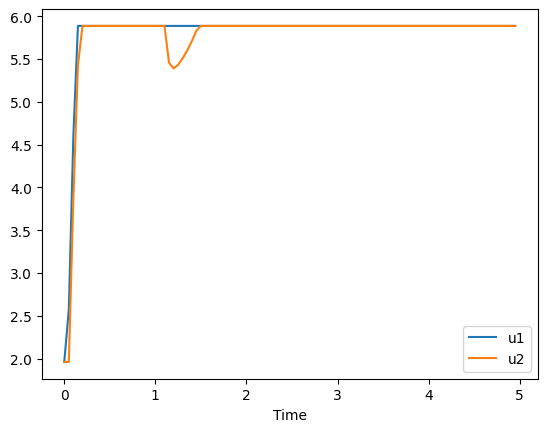

In [10]:
# Let's plot the commands
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K-1)], [us[k][0, 0] for k in range(K-1)], label="u1")
ax.plot([k * dt for k in range(K-1)], [us[k][1, 0] for k in range(K-1)], label="u2")

plt.xlabel("Time")

plt.legend();

**Now let's do MPC!**

In [41]:
# MPC stuff!
tc = 1. # 1 sec look ahead (horizon)
Nh = round(tc/dt)

# Let's build the QP matrices -- this is very similar to the QP version of LQR!
# Cost matrix
H = np.zeros(((Nh-1)*(M+N), (Nh-1)*(M+N)))
### TO-DO: Fill the matrix correctly (initial and final parts)
for k in range(Nh-1):
    H[k*(M+N)+M:(k+1)*(M+N), k*(M+N)+M:(k+1)*(M+N)] = Q
    H[    k*(M+N):k*(M+N)+M,     k*(M+N):k*(M+N)+M] = R
H[-N:, -N:] = QN
### END of TO-DO

# Cost vector
h = np.zeros(((Nh-1)*(M+N), 1))
print(f"size of h: {h.shape}")
print(f"size of H: {H.shape}")
# print(f"H[1,1] =\n{H[:6,:6]}")
# print(f"H[2,2] =\n{H[6:11,6:11]}")
# print(f"H[3,3] =\n{H[12:17,12:17]}")
print(f"H = \n{H}")
for k in range(Nh-2):
    ### TO-DO: Fill the matrix correctly (intermediate parts)
    h[k] = -2 * (H[k,k,:] @ x_ref)
    ### END of TO-DO
# # Equality Constraints (dynamics)
# size = (Nh-1)*(M+N)
# G = np.zeros(((Nh-1) * N, size))

# ### TO-DO: Fill the matrix correctly (initial and final parts)
# for k in range(Nh-1):
#     G[k*N:(k*N)+N, k*(M+N):k*(M+N)+M] = -B
#     if(k > 0): G[ k*N:(k*N)+N, k*(M+N)-N:k*(M+N)] = -A
#     G[ k*N:(k*N)+N, k*(M+N)+M:k*(M+N)+M+N] = np.eye(N)
# ### END of TO-DO
# for k in range(Nh-2):
#     ### TO-DO: Fill the matrix correctly (intermediate parts)
#     ### ...
#     ### END of TO-DO

# d = np.zeros(((Nh-1) * N, 1))
# d[:N, :] = -A @ x0 # We need to insert/update the initial state here!

# # Inequality Constraints (actuation limits)
# C = np.zeros(((Nh-1) * M, size))
# lb = np.zeros(((Nh-1) * M, 1))
# ub = np.zeros(((Nh-1) * M, 1))

# for k in range(Nh-1):
#     ### TO-DO: Fill correct the matrix and vectors
#     C[k*M:(k+1)*M, k*(M+N):k*(M+N)+M] = np.eye(M)
#     # First motor
#     lb[k*M: (k + 1) * M, :] = umin.reshape(-1, 1)
#     # Second motor
#     ub[k * M : (k + 1) * M, :] = umax.reshape(-1, 1)
#     ### END of TO-DO

size of h: (152, 1)
size of H: (152, 152)
H = 
[[0.01 0.   0.   ... 0.   0.   0.  ]
 [0.   0.01 0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [39]:
# Let's create the QP problem
# First let's import the library
import proxsuite

# Let's create the solver
qp_dim = H.shape[0]
qp_dim_eq = G.shape[0]
qp_dim_in = C.shape[0]
qp = proxsuite.proxqp.dense.QP(qp_dim, qp_dim_eq, qp_dim_in)

# initialize the model of the problem to solve
qp.init(H, h, G, d, C, lb, ub)
# Let's do an initial solve
qp.solve()

In [ ]:
# Now we create a function that would re-run the QP solver with the new state
prev_sol_x = qp.results.x
prev_sol_eq = qp.results.y
prev_sol_ineq = qp.results.z

def mpc_controller(x, x_ref = np.zeros((N, 1))):
    global prev_sol_x, prev_sol_eq, prev_sol_ineq

    # Let's update the matrices as needed
    ### TO-DO: Update the initial state
    ### ...
    ### END of TO-DO
    for k in range(Nh-2):
        ### TO-DO: Update the cost given the x_ref!
        ### ...
        ### END of TO-DO
    ### TO-DO: Update the final cost given the x_ref!
    ### ...
    ### END of TO-DO

    # Update qp problem
    qp.update(H, h, G, d, C, lb, ub)

    # Solve with warm start
    qp.solve(prev_sol_x, prev_sol_eq, prev_sol_ineq)

    prev_sol_x = qp.results.x
    prev_sol_eq = qp.results.y
    prev_sol_ineq = qp.results.z

    first_u = qp.results.x[:M].reshape((M, -1))

    return u_bar + first_u

In [ ]:
# Now let's create the same simulation but run the QP!
### TO-DO: Change x_ref
x_ref = np.array([[0., 1., 0., 0., 0., 0.]]).T
### END of TO-DO

# Initial State far away!
x0 = np.array([[6., 2., 1.5, 0., 0., 0.]]).T

us = []
states = [np.copy(x0)]
x = np.copy(x0)
for k in range(K-1):
    u_new = mpc_controller(x, x_ref)
    ### TO-DO: Copy clamp u_new inside u_min/u_max (use np.minimum/maximum functions)
    ### ....
    ### END of TO-DO
    x = planar_quad_rk4(x, u_new, dt)
    states.append(np.copy(x))
    us.append(np.copy(u_new))
print(cost(states, us, x_ref))

# Let's plot it
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [states[k][0, 0] for k in range(K)], label="x")
ax.plot([k * dt for k in range(K)], [states[k][1, 0] for k in range(K)], label="y")
ax.plot([k * dt for k in range(K)], [states[k][2, 0] for k in range(K)], label="θ")

plt.xlabel("Time")

plt.legend();

MPC can now reason about the actuation limits and manages to solve the problem!! Let's plot the controls as well to see what's going on:

In [ ]:
# Let's plot the commands
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K-1)], [us[k][0, 0] for k in range(K-1)], label="u1")
ax.plot([k * dt for k in range(K-1)], [us[k][1, 0] for k in range(K-1)], label="u2")

plt.xlabel("Time")

plt.legend();

### Trajectory Optimization with Trapezoidal Quadrature

Now let's try to generate behaviors/trajectories for the planar quadrotor using Trajectory Optimization with Trapezoidal Quadrature. Let's remind ourselves how trajectory optimization works.

We split the whole trajectory into $K$ knot points. For each segment (between knot point $k$ and knot point $k+1$), we perform the trapezoidal quadrature. In short,

- **Cost function:** $\int_{t_0}^{t_f}\ell(\boldsymbol{x}(t), \boldsymbol{u}(t))dt\approx\sum_{k=1}^{K-1}\frac{\big(\ell_{k+1}+\ell_k\big)}{2}(t_{k+1}-t_k)$
- **Dynamics constraints:** $\int_{t_k}^{t_{k+1}}\dot{\boldsymbol{x}}(t)dt\Rightarrow\boldsymbol{x}_{k+1}-\boldsymbol{x}_k\approx\frac{1}{2}(t_{k+1}-t_k)\big(f_{k+1}+f_k\big)$
- **All other constraints:** We usually evaluate them just at the knot points

where $t_k$ is the time at knot point $k$, $\ell_k$ is the cost function evaluated at knot point $k$, and $f_k$ is the continuous dynamics evaluated at knot point $k$ ($\boldsymbol{x}_k,\boldsymbol{u}_k$).

So, let's get going. First we need to import the *Ipopt* library that we will use for optimization.

In [ ]:
import cyipopt

We also need to write the derivatives of the system dynamics:

In [ ]:
# First, we re-write the `planar_quad` function with numpy (for speed, JAX inserts small overhead)
def planar_quad(x, u):
    x_dot = np.zeros((N,))

    x_dot[:3] = x[3:]
    x_dot[3] = -(u[0] + u[1]) * np.sin(x[2]) / m
    x_dot[4] = (u[0] + u[1]) * np.cos(x[2]) / m - g
    x_dot[5] = 0.5 * l / J * (u[1] - u[0])

    return x_dot

def quad_derivX(x, u):
    d_out = np.zeros((N, N))

    ### TO-DO: Fill out d_out
    ### ...
    #### END of TO-DO

    return d_out

def quad_derivU(x, u):
    d_out = np.zeros((N, M))

    ### TO-DO: Fill out d_out
    ### ...
    ### END of TO-DO

    return d_out

Then, let's redefine the initial and target states, the number of knot points and helper variables:

In [ ]:
### x_ref (target)
x_ref = np.array([[0., 1., 0., 0., 0., 0.]]).T

# Initial State
x_initial = np.array([[6., 2., 1.5, 0., 0., 0.]]).T

# Helper vars
tf = 5. # total time
dt = 0.05 # control rate
K = round(tf/dt) + 1 # here we implicitly assume that (t_{k+1}-t_k) = dt for all k
print('K=', K)

# We have K knot points for state and K-1 knot points for controls (no control available in the last step)
x_dim = K * N + (K - 1) * M
# We have K-1 "internal" dynamics constraints + 2 for the initial and final points (all equality constraints)
eq_dim = (K - 1) * N + 2 * N

Now we need to create the class required for *cyipopt* and fill it with our system. Initially, let's not care about an objective function.

In [ ]:
class PlanarQuadTrapezoidal:
    def __init__(self):
        pass

    def objective(self, x):
        # For now let's not care about the objective!
        return 0.

    def gradient(self, x):
        return np.zeros((x_dim,))

    def constraints(self, x):
        c = np.zeros((eq_dim,))

        for k in range(K-1):
            ### TO-DO: Fill c matrix
            ### ...
            ### END of TO-DO

        ### TO-DO: Add constraints for initial and final state
        ### ...
        ### END of TO-DO

        return c

    def jacobian(self, x):
        J = np.zeros((eq_dim, x_dim))
        for k in range(K-1):
            ### TO-DO: Fill the Jacobian!
            ### ...
            ### END of TO-DO

        ### TO-DO: Fill Jacobian for initial and final state constraints
        ### ...
        ### END of TO-DO
        
        return J

In [ ]:
# Let's solve the problem!
x0 = np.zeros((x_dim,))
# Initialization
for k in range(K):
    # position
    x0[k * N : k * N + 3] = x_ref[:3, 0] * float(k) / (K - 1.) + x_initial[:3, 0]
    # velocity
    x0[k * N + 3 : k * N + N] = x_ref[:3, 0] / tf
# u's
for k in range(K - 1):
    x0[K * N + k * M : K * N + k * M + M] = m * g / 2.

lb = [None] * x_dim
ub = [None] * x_dim

# Add u bounds
for k in range(K - 1):
    lb[K * N + k * M : K * N + k * M + M] = [0.2 * m * g for _ in range(M)]
    ub[K * N + k * M : K * N + k * M + M] = [0.6 * m * g for _ in range(M)]

# All constraints are equality constraints
cl = [0.] * eq_dim
cu = [0.] * eq_dim

nlp = cyipopt.Problem(n=len(x0), m=len(cl), problem_obj=PlanarQuadTrapezoidal(), lb=lb, ub=ub, cl=cl, cu=cu)

nlp.add_option("jacobian_approximation", "exact") # "finite-difference-values")
nlp.add_option("print_level", 3)
nlp.add_option("nlp_scaling_method", "none")


# Solve the problem
x, info = nlp.solve(x0)

In [ ]:
# Let's plot the trajectory found!
fig = plt.figure()  # no frame
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [x[k * N + 0] for k in range(K)], label="x")
ax.plot([k * dt for k in range(K)], [x[k * N + 1] for k in range(K)], label="y")
ax.plot([k * dt for k in range(K)], [x[k * N + 2] for k in range(K)], label="θ")

# ax.plot([k * dt for k in range(K)], [x[k * N + 3] for k in range(K)], label="$\dot{x}$")
# ax.plot([k * dt for k in range(K)], [x[k * N + 4] for k in range(K)], label="$\dot{y}$")
# ax.plot([k * dt for k in range(K)], [x[k * N + 5] for k in range(K)], label="$\dot{θ}$")

# ax.plot([k * dt for k in range(K - 1)], [x[K * N + k * M + 0] for k in range(K - 1)], label="u1")
# ax.plot([k * dt for k in range(K - 1)], [x[K * N + k * M + 1] for k in range(K - 1)], label="u2")

plt.xlabel("Time")

plt.legend();

The results seem slightly weird. Now let's also add the cost function to see the difference in the result!

In [ ]:
class PlanarQuadTrapezoidal:
    def __init__(self):
        pass

    def objective(self, x):
        # Let's calculate the objective/cost: almost identical to the `cost()` function we had for LQR/MPC
        xN = x[(K - 1) * N : K * N].reshape((N,1))
        diff = (xN - x_ref)
        c = 0.5 * diff.T @ QN @ diff
        for k in range(K-1):
            ### TO-DO: Compute the cost function
            ### ...
            ### END of TO-DO
        return c[0][0]

    def gradient(self, x):
        g = np.zeros((x_dim,))
        ### TO-DO: Fill g appropriately with the gradient of the cost function
        ### ...
        ### END of TO-DO
        return g

    def constraints(self, x):
        c = np.zeros((eq_dim,))

        for k in range(K-1):
            ### TO-DO: Copy c matrix computation from above
            ### ...
            ### END of TO-DO

        ### TO-DO: Copy constraints for initial and final state from above
        ### ...
        ### END of TO-DO

        return c

    def jacobian(self, x):
        J = np.zeros((eq_dim, x_dim))
        for k in range(K-1):
            ### TO-DO: Copy the Jacobian from above
            ### ...
            ### END of TO-DO

        ### TO-DO: Copy Jacobian for initial and final state constraints from above
        ### ...
        ### END of TO-DO
        
        return J

In [ ]:
# Let's solve the problem!
x0 = np.zeros((x_dim,))
# Initialization
for k in range(K):
    # position
    x0[k * N : k * N + 3] = x_ref[:3, 0] * float(k) / (K - 1.) + x_initial[:3, 0]
    # velocity
    x0[k * N + 3 : k * N + N] = x_ref[:3, 0] / tf
# u's
for k in range(K - 1):
    x0[K * N + k * M : K * N + k * M + M] = m * g / 2.

lb = [None] * x_dim
ub = [None] * x_dim

# Add u bounds
for k in range(K - 1):
    lb[K * N + k * M : K * N + k * M + M] = [0.2 * m * g for _ in range(M)]
    ub[K * N + k * M : K * N + k * M + M] = [0.6 * m * g for _ in range(M)]

# All constraints are equality constraints
cl = [0.] * eq_dim
cu = [0.] * eq_dim

nlp = cyipopt.Problem(n=len(x0), m=len(cl), problem_obj=PlanarQuadTrapezoidal(), lb=lb, ub=ub, cl=cl, cu=cu)

nlp.add_option("jacobian_approximation", "exact") # "finite-difference-values")
nlp.add_option("print_level", 3)
nlp.add_option("nlp_scaling_method", "none")
# When inserting a cost function, the optimizer might need too many calls to converge to the absolute local minimum; we can reduce the tolerance to avoid this
nlp.add_option("tol", 1e-3)


# Solve the problem
x, info = nlp.solve(x0)

In [ ]:
# Let's plot the trajectory found!
fig = plt.figure()  # no frame
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [x[k * N + 0] for k in range(K)], label="x")
ax.plot([k * dt for k in range(K)], [x[k * N + 1] for k in range(K)], label="y")
ax.plot([k * dt for k in range(K)], [x[k * N + 2] for k in range(K)], label="θ")

# ax.plot([k * dt for k in range(K)], [x[k * N + 3] for k in range(K)], label="$\dot{x}$")
# ax.plot([k * dt for k in range(K)], [x[k * N + 4] for k in range(K)], label="$\dot{y}$")
# ax.plot([k * dt for k in range(K)], [x[k * N + 5] for k in range(K)], label="$\dot{θ}$")

# ax.plot([k * dt for k in range(K - 1)], [x[K * N + k * M + 0] for k in range(K - 1)], label="u1")
# ax.plot([k * dt for k in range(K - 1)], [x[K * N + k * M + 1] for k in range(K - 1)], label="u2")

plt.xlabel("Time")

plt.legend();

In [ ]:
%matplotlib
import matplotlib.pyplot as plt # Plotting

plt.ion()
fig = plt.figure()
# for stopping simulation with the esc key.
fig.canvas.mpl_connect('key_release_event', lambda event: [exit(0) if event.key == 'escape' else None])

ax = fig.add_subplot(1, 1, 1)

for k in range(K):
    plt.cla()
    plt.xlim(-1.5, 7.)
    plt.ylim(-1., 3.)
    ct = np.cos(x[k * N + 2])
    st = np.sin(x[k * N + 2])
    ax.plot([x[k * N + 0] - l/2. * ct, x[k * N + 0] + l/2. * ct], [x[k * N + 1] - l/2. * st, x[k * N + 1] + l/2. * st])
    plt.pause(0.1)

plt.close();